In [1]:
# https://arxiv.org/abs/1610.02415

# https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html

import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
import torch.distributed as dist

import torch_geometric
import torch_geometric.nn as gnn
#print(torch_geometric.__version__)
from torch_geometric.datasets import QM9
import GCL.augmentors
import GCL.augmentors as A

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error, r2_score
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression, LinearRegression
import itertools

import GCL.augmentors as A
from GCL.augmentors import node_dropping, ppr_diffusion, feature_dropout, edge_adding, rw_sampling
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available else 'cpu'
print(device)

1.13.1+cu117
cuda


In [2]:

parameters = {}
parameters['batch_size'] = 4096

In [21]:
whole_dataset = QM9(root = 'data/')

#print(whole_dataset.get_summary())
#print(dir(whole_dataset))
#print(whole_dataset.len())

n = whole_dataset.len()
tr_n = 2000 # Number of QM9 to use as training data

all_inds = range(n)
tr_inds, val_inds = train_test_split(all_inds, train_size = tr_n)
print(len(tr_inds), len(val_inds))
print(type(tr_inds), type(tr_inds[0]))


train_sampler = torch.utils.data.SubsetRandomSampler(tr_inds)
val_sampler = torch.utils.data.SubsetRandomSampler(val_inds)

# We need to make a train and validation set since QM9 does not provide them
train_set = torch.utils.data.Subset(whole_dataset, tr_inds)
val_set = torch.utils.data.Subset(whole_dataset, val_inds)

train_loader = torch_geometric.loader.DataLoader(train_set, batch_size = parameters['batch_size'],
                                                shuffle = True, num_workers = 2,)
                                                #sampler = train_sampler)
big_train_loader = torch_geometric.loader.DataLoader(train_set, batch_size = int(1e9),
                                                shuffle = True, num_workers = 2,)

val_loader = torch_geometric.loader.DataLoader(val_set, batch_size=2048,
                                            shuffle=False, num_workers=2,)
                                              #sampler = val_sampler)
    
val_aug = A.RandomChoice([], num_choices = 0)


2000 128831
<class 'list'> <class 'int'>


In [22]:
qm9_index = {0: 'Dipole moment',
1: 'Isotropic polarizability',
2: 'Highest occupied molecular orbital energy',
3: 'Lowest unoccupied molecular orbital energy',
4: 'Gap between previous 2',
5: 'Electronic spatial extent',
6: 'Zero point vibrational energy',
7: 'Internal energy at 0K',
8: 'Internal energy at 298.15K',
9: 'Enthalpy at 298.15K',
10: 'Free energy at 298.15K',
11: 'Heat capavity at 298.15K',
12: 'Atomization energy at 0K',
13: 'Atomization energy at 298.15K',
14: 'Atomization enthalpy at 298.15K',
15: 'Atomization free energy at 298.15K',
16: 'Rotational constant A',
17: 'Rotational constant B',
18: 'Rotational constant C',}

print(qm9_index.items())

dict_items([(0, 'Dipole moment'), (1, 'Isotropic polarizability'), (2, 'Highest occupied molecular orbital energy'), (3, 'Lowest unoccupied molecular orbital energy'), (4, 'Gap between previous 2'), (5, 'Electronic spatial extent'), (6, 'Zero point vibrational energy'), (7, 'Internal energy at 0K'), (8, 'Internal energy at 298.15K'), (9, 'Enthalpy at 298.15K'), (10, 'Free energy at 298.15K'), (11, 'Heat capavity at 298.15K'), (12, 'Atomization energy at 0K'), (13, 'Atomization energy at 298.15K'), (14, 'Atomization enthalpy at 298.15K'), (15, 'Atomization free energy at 298.15K'), (16, 'Rotational constant A'), (17, 'Rotational constant B'), (18, 'Rotational constant C')])


In [23]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.rep_dim = 128
        self.emb_dim = 256
        
        # Data under graph
        self.conv1 = GCNConv(whole_dataset.num_node_features, self.rep_dim // 2)
        self.bn1 = nn.BatchNorm1d(self.rep_dim // 2)
        self.a1 = nn.LeakyReLU(0.02)
        
        self.conv2 = GCNConv(self.rep_dim // 2, self.rep_dim) # To Rep Space
        self.bn2 = nn.BatchNorm1d(self.rep_dim)
        
        # Projection to representation
        self.mpool1 = gnn.global_mean_pool
        #self.fc1 = nn.Linear(self.rep_dim, self.rep_dim)
        
        # Graph 2
        self.conv3 = GCNConv(self.rep_dim, self.rep_dim * 2) # To Emb Space
        self.bn3 = nn.BatchNorm1d(self.rep_dim * 2)
        
        # Projection to embedding
        #self.mpool2 = gnn.global_mean_pool
        #self.fc2 = nn.Linear(self.emb_dim, self.emb_dim) # Linear to rep?
        
    def forward(self, data, binds):
        x = data[0].float().to(device)
        edge_index = data[1].to(device)
        
        x = self.conv1(x, edge_index)
        x = self.a1(self.bn1(x))
        x = F.dropout(x, training=self.training)
        
        x = self.bn2(self.conv2(x, edge_index))
        
        x_rep = self.mpool1(x, binds)
        
        x_emb = self.conv3(x, edge_index)
        return x_rep, x_emb



def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

def VicRegLoss(x, y):
    # https://github.com/facebookresearch/vicreg/blob/4e12602fd495af83efd1631fbe82523e6db092e0/main_vicreg.py#L184
    # x, y are output of projector(backbone(x and y))
    
    # These are the default params used in natural image vicreg
    sim_coeff = 25
    std_coeff = 25
    cov_coeff = 1
    
    
    repr_loss = F.mse_loss(x, y)

    x = x - x.mean(dim=0)
    y = y - y.mean(dim=0)

    std_x = torch.sqrt(x.var(dim=0) + 0.0001)
    std_y = torch.sqrt(y.var(dim=0) + 0.0001)
    std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

    cov_x = (x.T @ x) / (parameters['batch_size'] - 1)
    cov_y = (y.T @ y) / (parameters['batch_size'] - 1)
    cov_loss = off_diagonal(cov_x).pow_(2).sum().div(
        x.shape[1]
    ) + off_diagonal(cov_y).pow_(2).sum().div(x.shape[1])
    
    # self.num_features -> rep_dim?
    loss = (
        sim_coeff * repr_loss
        + std_coeff * std_loss
        + cov_coeff * cov_loss
    )
    return loss


def train(parameters):
    
    device = 'cuda'

    model = GCN().to(device)
    n_epochs = 20

    
    row_ind = 0
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=5e-4)
    transfer_mat = torch.zeros((len(qm9_index.keys()), 6))

    tr_losses = []
    val_losses = []

    for epoch in range(0,n_epochs+1):
        epoch_losses = []
        for batch in train_loader:
            optimizer.zero_grad()

            batch_inds = batch.batch.to(device)

            # batch of graphs has edge attribs, node attribs - (n_nodes, n_features+1) -> concat (n_nodes, attrib1)

            batch.x = batch.x.float()#.to(device)
            #batch.edge_index = batch.edge_index.to(device)

            # Barlow - get 2 random views of batch
            #print(batch.x, batch.edge_index, batch.edge_attr)
            #print(aug, type(aug))
            b1 = aug(batch.x, batch.edge_index, batch.edge_attr)
            b2 = aug(batch.x, batch.edge_index, batch.edge_attr)

            # Embed each batch (ignoring representations)
            r1, e1 = model(b1, batch_inds)
            r2, e2 = model(b2, batch_inds)

            loss = VicRegLoss(e1, e2)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.data.item())

        print('epoch train loss', sum(epoch_losses) / len(epoch_losses))
        tr_losses.append(sum(epoch_losses) / len(epoch_losses))

        if epoch % 4 == 0:

            # Downstream supervised loss
            
#             for batch in big_train_loader: # take entire train set
#                 with torch.no_grad():
#                     # Embed training set under model
#                     rep_tr, _ = model(val_aug(batch.x, batch.edge_index, batch.edge_attr), batch.batch.to(device))


#                     for val_batch in val_loader:
#                         # Embed validation set under model
#                         rep_val, _ = model(val_aug(val_batch.x, val_batch.edge_index, val_batch.edge_attr), val_batch.batch.to(device))

#                         # For each task in QM9
#                         for tar_ind in range(batch.y.shape[1]):
#                             # Fit a model on model representation of train set

#                             #print(rep_tr.shape, batch.y[tar_ind].shap)
#                             lm = LinearRegression().fit(rep_tr.cpu(), batch.y[:,tar_ind])
#                             # Test the model on model repersentation of val set
#                             tar_yhat = lm.predict(rep_val.cpu())
#                             mse_met = mean_squared_error(val_batch.y[:,tar_ind], tar_yhat).item()
#                             r2_met = r2_score(val_batch.y[:,tar_ind], tar_yhat)
#                             #print(qm9_index[tar_ind], mse_met, r2_met)
#                             transfer_mat[tar_ind, row_ind] = mse_met
#                         row_ind += 1

            # VicReg Validation Loss
            val_loss = []
            for batch in val_loader:
                with torch.no_grad():
                    # VicReg validation loss
                    b1 = aug(batch.x, batch.edge_index, batch.edge_attr)
                    b2 = aug(batch.x, batch.edge_index, batch.edge_attr)
                    r1, e1 = model(b1, batch.batch.to(device))
                    r2, e2 = model(b2, batch.batch.to(device))

                    val_loss.append(VicRegLoss(e1, e2).item())

            val_losses.append(torch.mean(torch.FloatTensor(val_loss)))

    #plt.plot(tr_losses)
    plt.plot(val_losses, label = parameters['aug_str'])
    
    return model, tr_losses, val_losses, transfer_mat

import os
def trymkdir(path):
    if os.path.exists(path):
        pass
    else:
        os.mkdir(path)

In [24]:
# Here is sample code for how to implement an "ablation" of 2-at-a-time augmentations
import GCL.augmentors as A
from GCL.augmentors import node_dropping, ppr_diffusion, feature_dropout, edge_adding, rw_sampling

aug = A.RandomChoice([#A.RWSampling(num_seeds=1000, walk_length=10),
                      A.NodeDropping(pn=0.1),
                      A.FeatureMasking(pf=0.1),
                      A.EdgeRemoving(pe=0.1)],
                     num_choices=1)

print(aug, type(aug))

# From a set of augmentations of length n_augmentations
aug_set = [A.NodeDropping(pn=0.1), A.FeatureMasking(pf=0.1), A.EdgeRemoving(pe=0.1), A.EdgeAdding(pe=0.1)]
           #ppr_diffusion, feature_dropout, edge_adding, rw_sampling]
    #A.PPRDiffusion()
aug_strs = ['NodeDropping', 'FeatureMasking', 'EdgeRemoving', 'EdgeAdding']
print(aug_strs)

# First get all pairs of indexes on-off in a list of length n_augmentations
aug_inds = list(itertools.product([0, 1], repeat=len(aug_set)))
aug_inds = [x for x in aug_inds if sum(x)==1]
print(aug_inds)

# Then for each augmentation, train and test a VicReg model trained under that augment
parameters = {}
parameters['batch_size'] = 64
parameters['learning_rate'] = 0.002
# etc parameters here which define model, hparams

for aug_index in aug_inds:

    tr_augs = []
    tr_strs = []
    for ind, augi in enumerate(aug_index):
        if augi == 1:
            tr_augs.append(aug_set[ind])
            tr_strs.append(aug_strs[ind])
            
    print(tr_strs)
    trymkdir(f'aug_sweep1/{tr_strs[0]}')
    
    tr_aug = A.RandomChoice(tr_augs, num_choices = 1)
    
    #print(tr_aug, type(tr_aug))
    parameters['train_aug'] = tr_aug
    parameters['aug_str'] = tr_strs
    
    model, train_loss, val_loss, transfer_mat = train(parameters)
    #transfer_scores = transfer_score(model, parameters)
    
    #print(transfer_mat)
    torch.save(model.state_dict(), f'aug_sweep1/{tr_strs[0]}/model.pt')
    torch.save(train_loss,  f'aug_sweep1/{tr_strs[0]}/train_loss.pt')
    torch.save(val_loss,  f'aug_sweep1/{tr_strs[0]}/val_loss.pt')
    torch.save(transfer_mat,  f'aug_sweep1/{tr_strs[0]}/transfer_mat.pt')
    
plt.legend()
plt.show()
    

<GCL.augmentors.augmentor.RandomChoice object at 0x000001ED2EF995A0> <class 'GCL.augmentors.augmentor.RandomChoice'>
['NodeDropping', 'FeatureMasking', 'EdgeRemoving', 'EdgeAdding']
[(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)]
['EdgeAdding']


KeyboardInterrupt: 

['NodeDropping', 'FeatureMasking', 'EdgeRemoving', 'EdgeAdding']
[(0, 1, 1, 1), (1, 0, 1, 1), (1, 1, 0, 1), (1, 1, 1, 0)]
['FeatureMasking', 'EdgeRemoving', 'EdgeAdding']


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


epoch train loss 536.2751307487488
epoch train loss 75.96628957986832
epoch train loss 47.35978978872299
epoch train loss 36.405102610588074
epoch train loss 32.350199818611145
epoch train loss 30.790001034736633
epoch train loss 27.873751282691956
epoch train loss 27.110714614391327
epoch train loss 26.303257882595062
epoch train loss 25.84874254465103
epoch train loss 25.47516357898712
epoch train loss 24.76890504360199
epoch train loss 24.38036197423935
epoch train loss 24.40793126821518
epoch train loss 24.386810660362244
epoch train loss 24.479893505573273
epoch train loss 24.141082525253296
epoch train loss 24.000535905361176
epoch train loss 24.17872053384781
epoch train loss 23.869184255599976
epoch train loss 23.689085125923157
tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0.

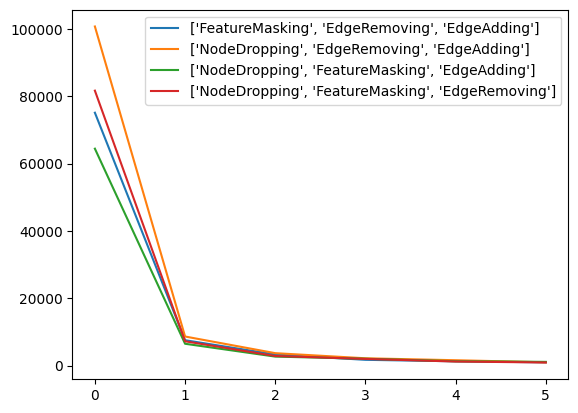

In [35]:
# Here is sample code for how to implement an "ablation" of 2-at-a-time augmentations


# From a set of augmentations of length n_augmentations
aug_set = [A.NodeDropping(pn=0.1), A.FeatureMasking(pf=0.1), A.EdgeRemoving(pe=0.1), A.EdgeAdding(pe=0.1)]
           #ppr_diffusion, feature_dropout, edge_adding, rw_sampling]
    #A.PPRDiffusion()
aug_strs = ['NodeDropping', 'FeatureMasking', 'EdgeRemoving', 'EdgeAdding']
print(aug_strs)

# First get all pairs of indexes on-off in a list of length n_augmentations
aug_inds = list(itertools.product([0, 1], repeat=len(aug_set)))
aug_inds = [x for x in aug_inds if sum(x)==3]
print(aug_inds)

# Then for each augmentation, train and test a VicReg model trained under that augment
parameters = {}
parameters['batch_size'] = 64
parameters['learning_rate'] = 0.002

experiment = 'aug_sweep3-4'
trymkdir(experiment)
# etc parameters here which define model, hparams

for aug_index in aug_inds:

    tr_augs = []
    tr_strs = []
    for ind, augi in enumerate(aug_index):
        if augi == 1:
            tr_augs.append(aug_set[ind])
            tr_strs.append(aug_strs[ind])
            
    print(tr_strs)
    trymkdir(f'{experiment}/{tr_strs}')
    
    tr_aug = A.RandomChoice(tr_augs, num_choices = 1)
    
    #print(tr_aug, type(tr_aug))
    parameters['train_aug'] = tr_aug
    parameters['aug_str'] = tr_strs
    
    model, train_loss, val_loss, transfer_mat = train(parameters)
    #transfer_scores = transfer_score(model, parameters)
    
    #print(transfer_mat)
    torch.save(model.state_dict(), f'{experiment}/{tr_strs}/model.pt')
    torch.save(train_loss,  f'{experiment}/{tr_strs}/train_loss.pt')
    torch.save(val_loss,  f'{experiment}/{tr_strs}/val_loss.pt')
    torch.save(transfer_mat,  f'{experiment}/{tr_strs}/transfer_mat.pt')
    
plt.legend()
plt.show()
    

[tensor(1828894.7500), tensor(780778.3750), tensor(512330.7812), tensor(348807.1250), tensor(254112.5938), tensor(188158.9219)]
[tensor(1719165.), tensor(625150.3750), tensor(465816.8438), tensor(359072.7500), tensor(250959.7500), tensor(187675.8750)]
[tensor(1826628.2500), tensor(694193.2500), tensor(461897.5312), tensor(363121.5312), tensor(268356.2812), tensor(194357.5938)]
[tensor(1691968.3750), tensor(673422.0625), tensor(454502.5625), tensor(331160.8750), tensor(244999.9062), tensor(175882.2812)]


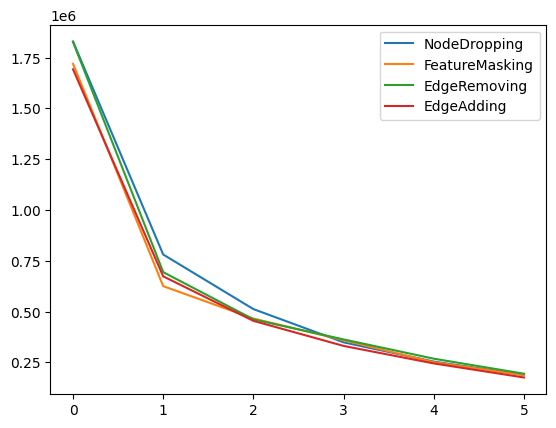

In [28]:
mse_scores = torch.zeros((19, len(aug_strs)))
for i_str, stri in enumerate(aug_strs):
    vec = torch.load(f'aug_sweep1/{stri}/val_loss.pt')
    
    model = GCN().to(device)
    model.load_state_dict(torch.load(f'aug_sweep1/{stri}/model.pt'))
    
    plt.plot(vec, label = stri)
    print(vec)
    
    for batch in big_train_loader: # take entire train set
        with torch.no_grad():
            # Embed training set under model
            rep_tr, _ = model(val_aug(batch.x, batch.edge_index, batch.edge_attr), batch.batch.to(device))


            for val_batch in val_loader:
                # Embed validation set under model
                rep_val, _ = model(val_aug(val_batch.x, val_batch.edge_index, val_batch.edge_attr), val_batch.batch.to(device))

                # For each task in QM9
                for tar_ind in range(batch.y.shape[1]):
                    # Fit a model on model representation of train set

                    #print(rep_tr.shape, batch.y[tar_ind].shap)
                    lm = LinearRegression().fit(rep_tr.cpu(), batch.y[:,tar_ind])
                    # Test the model on model repersentation of val set
                    tar_yhat = lm.predict(rep_val.cpu())
                    mse_met = mean_squared_error(val_batch.y[:,tar_ind], tar_yhat).item()
                    r2_met = r2_score(val_batch.y[:,tar_ind], tar_yhat)
                    #print(qm9_index[tar_ind], mse_met, r2_met)
                    mse_scores[tar_ind, i_str] = mse_met
    
plt.legend()
plt.show()

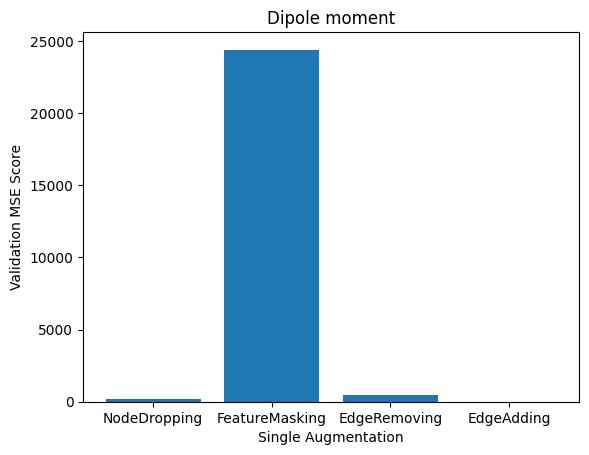

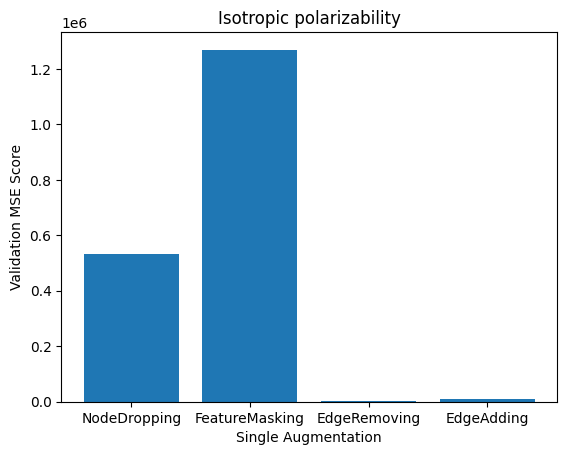

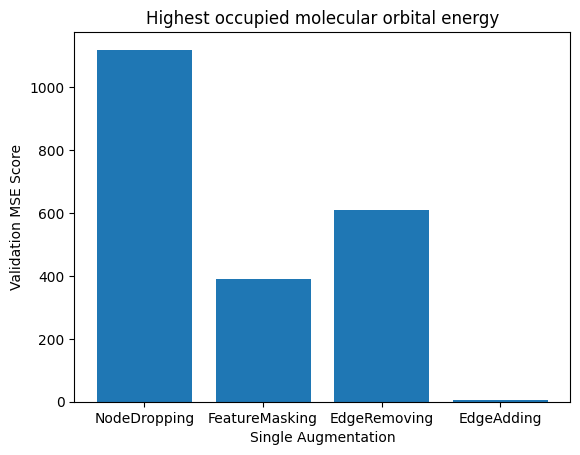

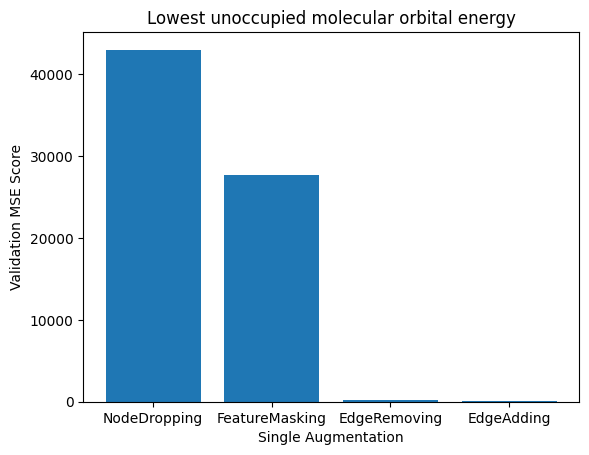

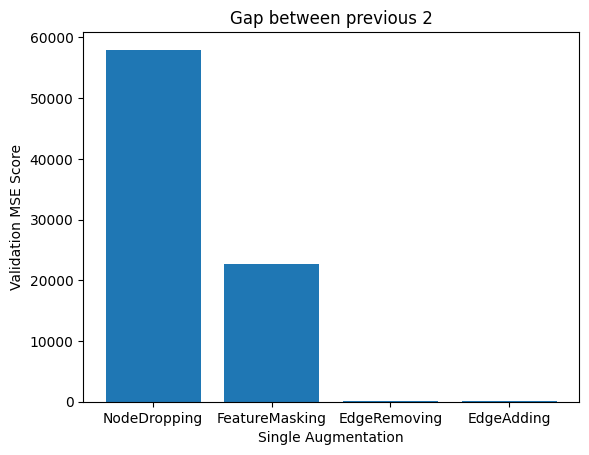

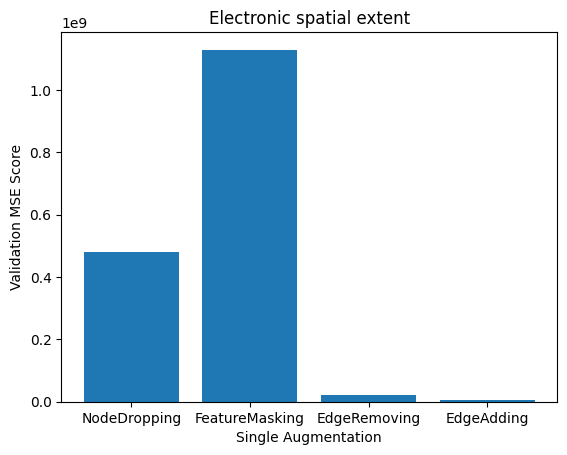

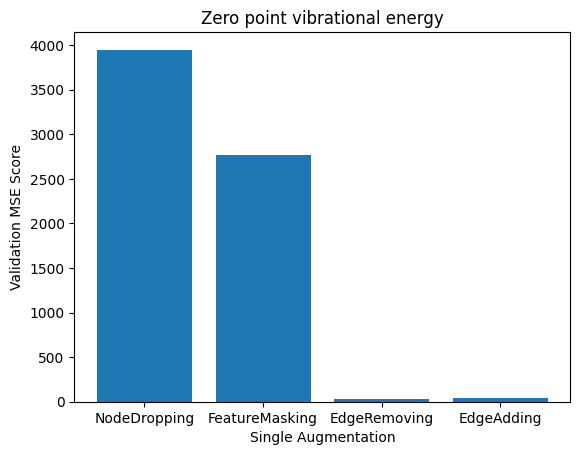

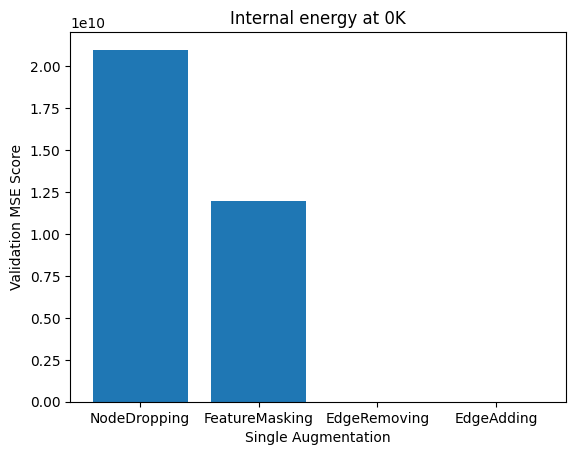

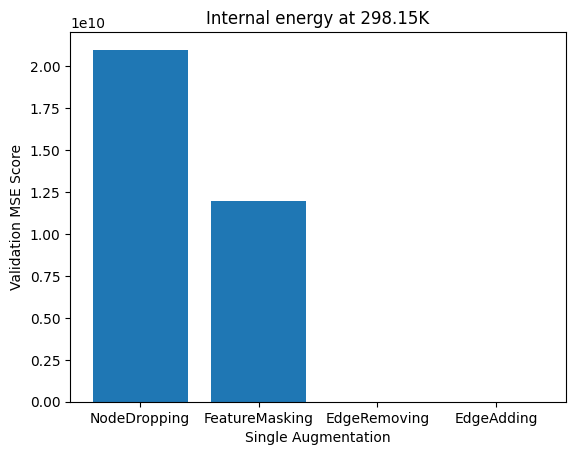

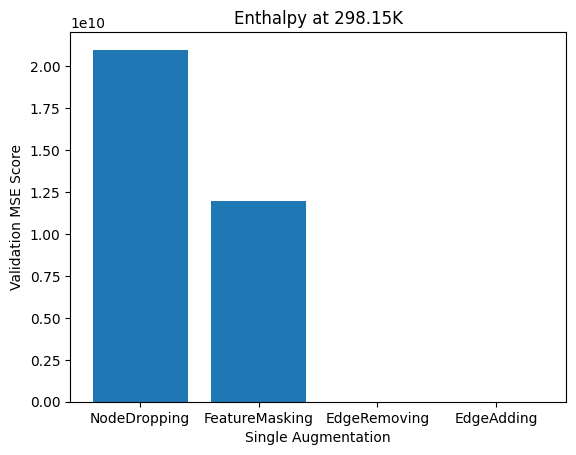

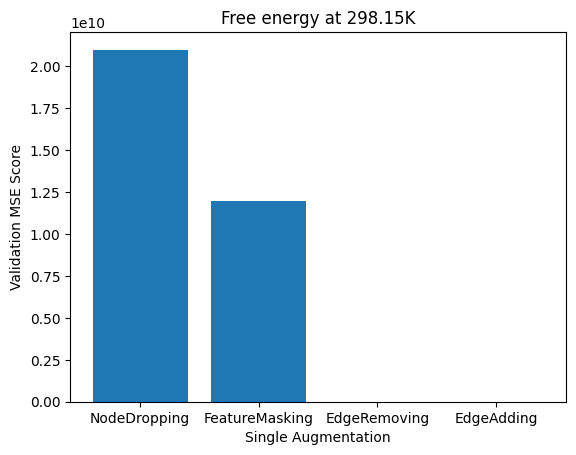

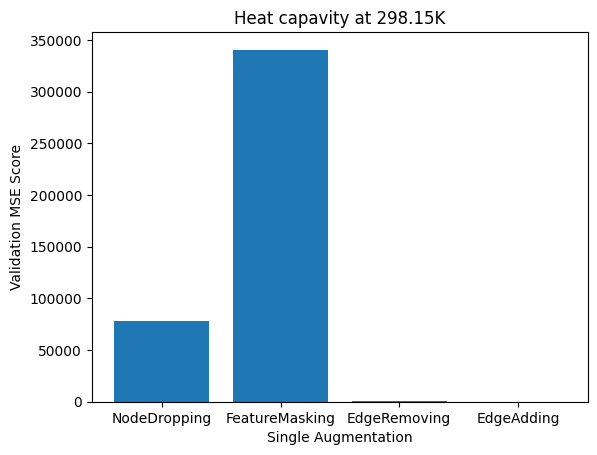

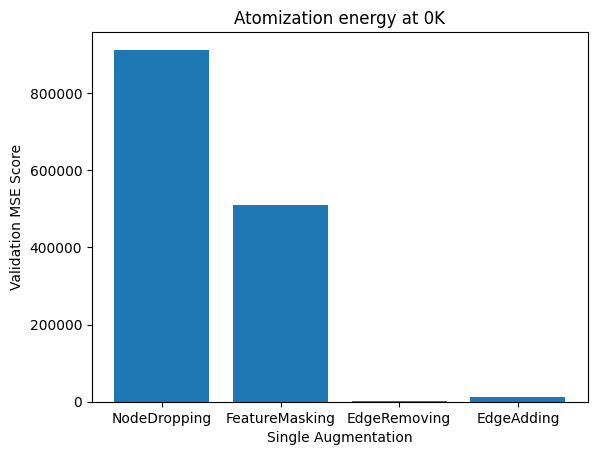

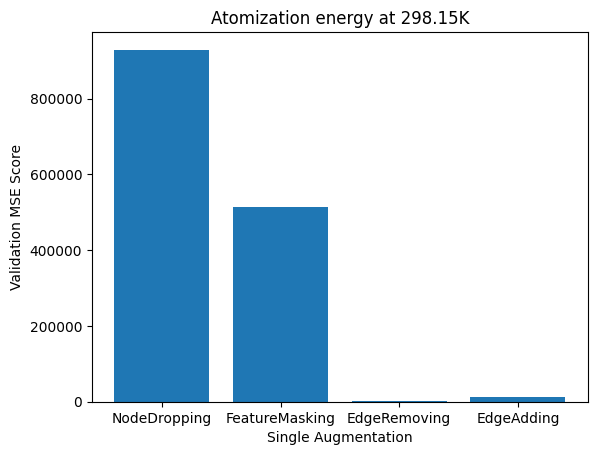

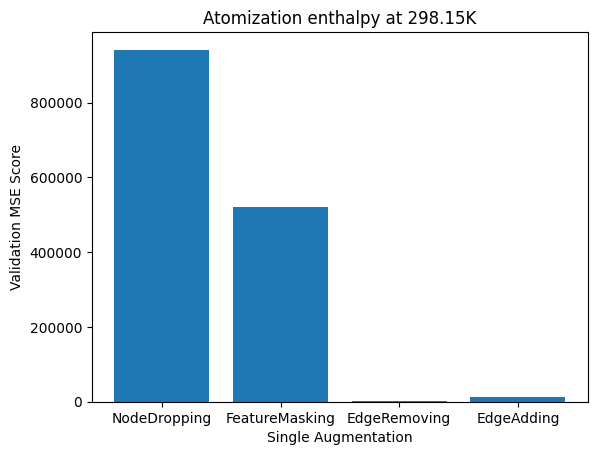

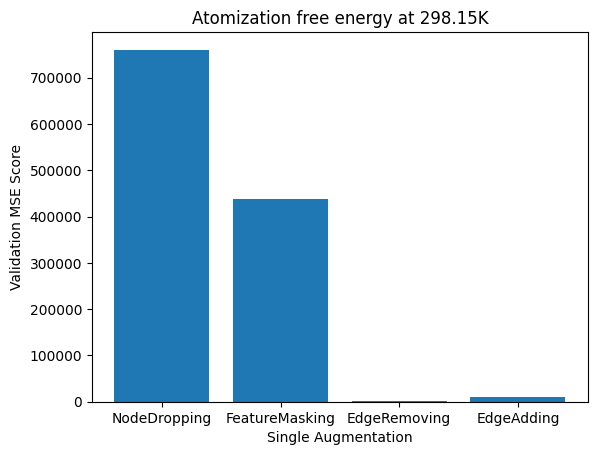

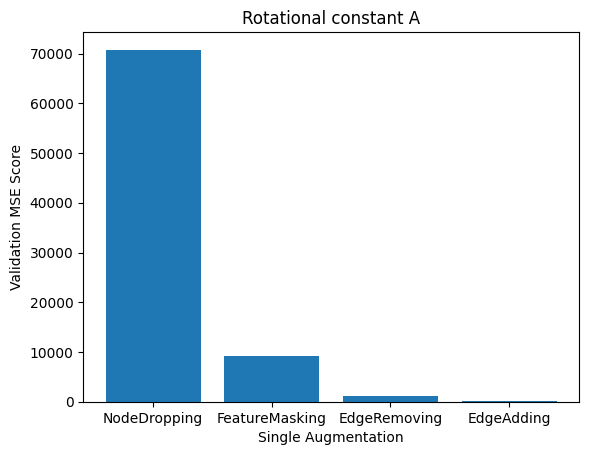

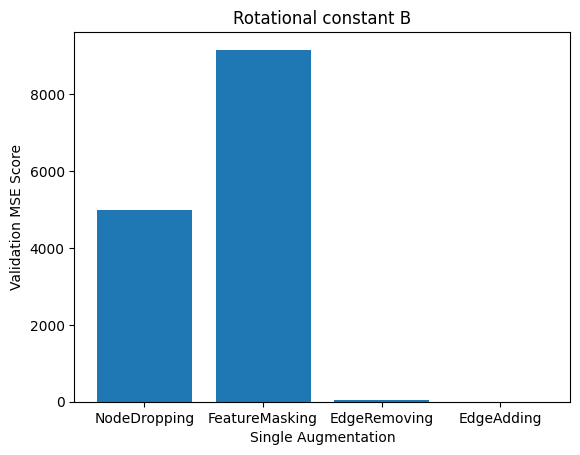

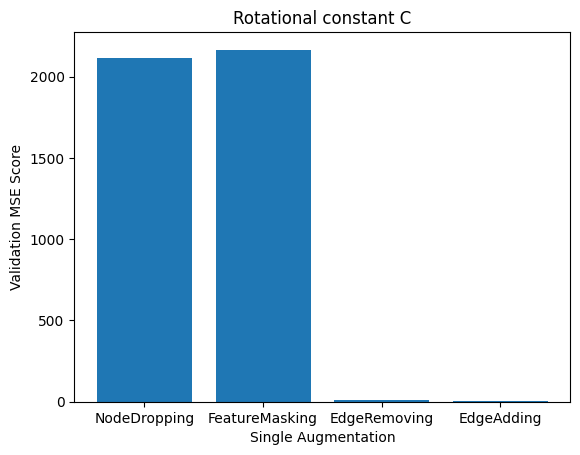

KeyError: 19

In [34]:
#print(mse_scores, mse_scores.shape)

# For one score, 

for i, row in enumerate(mse_scores):
    name = qm9_index[i]
    
    plt.bar(x = range(len(row)), height = row)
    plt.xticks(range(len(row)), aug_strs)
    plt.xlabel('Single Augmentation')
    plt.ylabel('Validation MSE Score')
    plt.title(name)
    plt.show()

["['FeatureMasking', 'EdgeRemoving', 'EdgeAdding']", "['NodeDropping', 'EdgeRemoving', 'EdgeAdding']", "['NodeDropping', 'FeatureMasking', 'EdgeAdding']", "['NodeDropping', 'FeatureMasking', 'EdgeRemoving']"]
[tensor(75096.6797), tensor(7518.8770), tensor(3273.9546), tensor(1695.7098), tensor(1261.6902), tensor(951.0359)]
[tensor(100711.6484), tensor(8619.2217), tensor(3671.5842), tensor(2152.5889), tensor(1573.8800), tensor(959.9286)]
[tensor(64412.1602), tensor(6466.7529), tensor(2652.4893), tensor(2014.9814), tensor(1270.6403), tensor(1084.8472)]
[tensor(81647.9531), tensor(7198.6704), tensor(2831.6943), tensor(1963.1010), tensor(1187.8834), tensor(905.9548)]


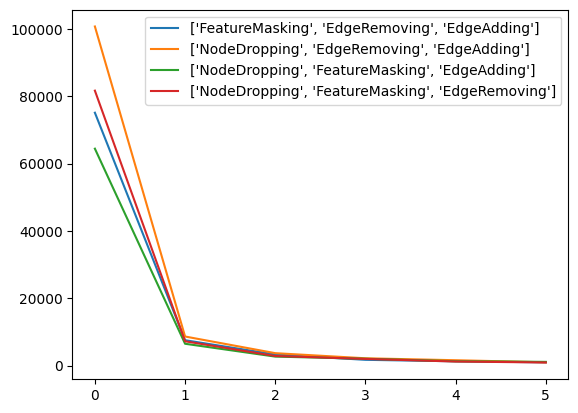

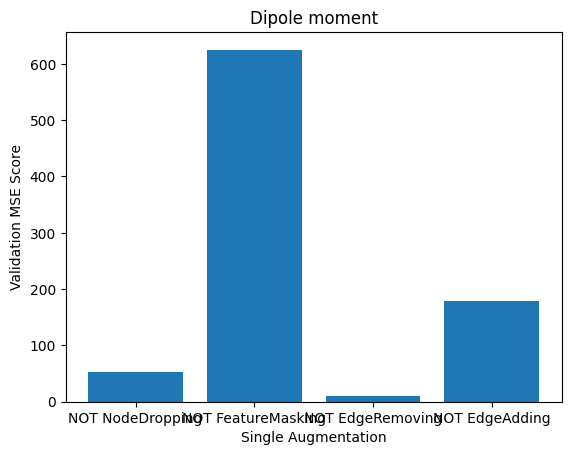

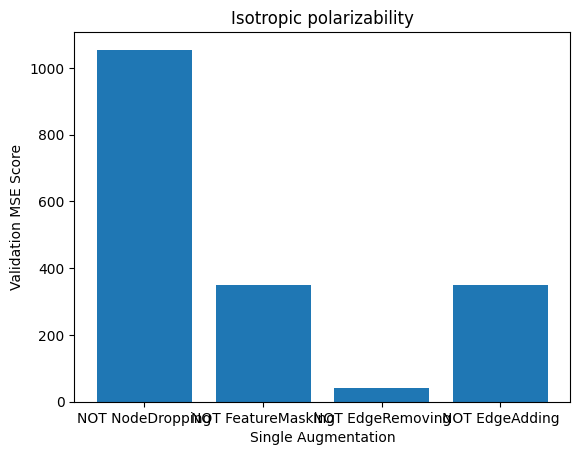

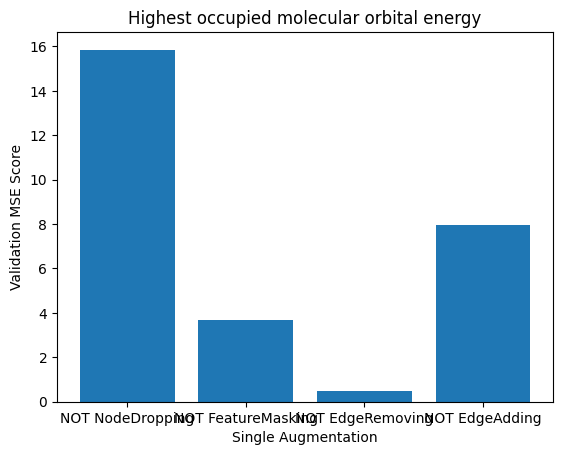

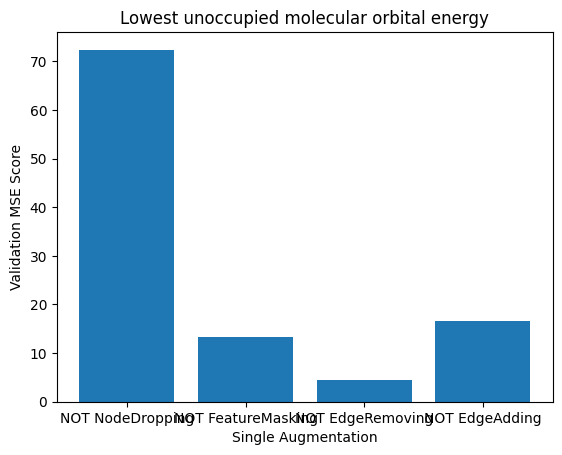

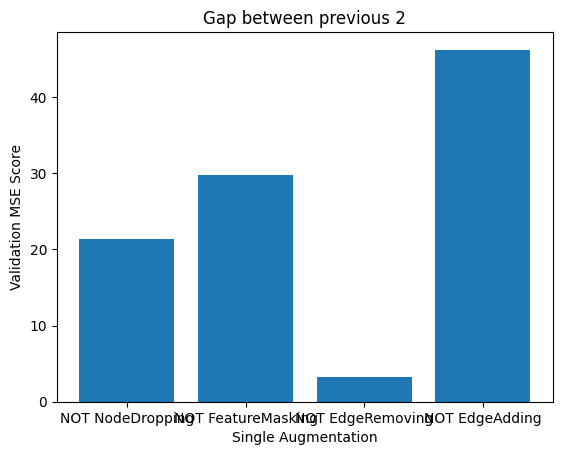

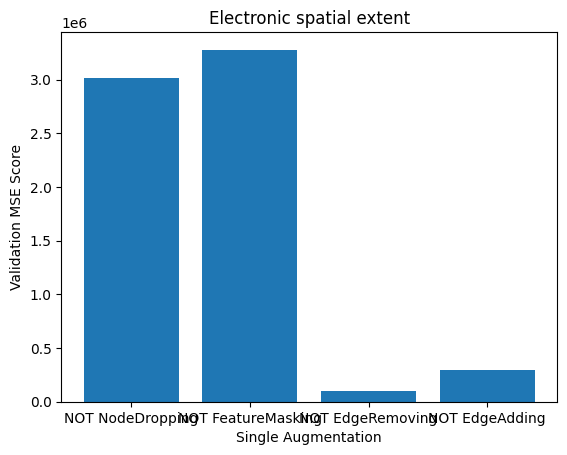

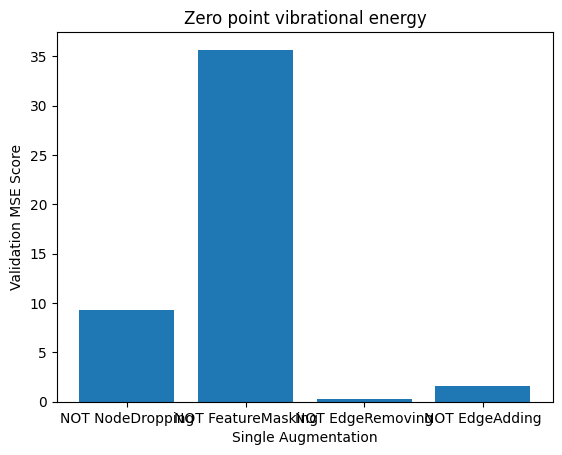

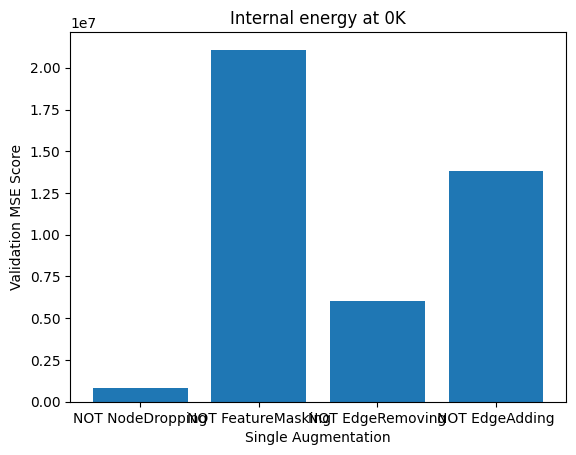

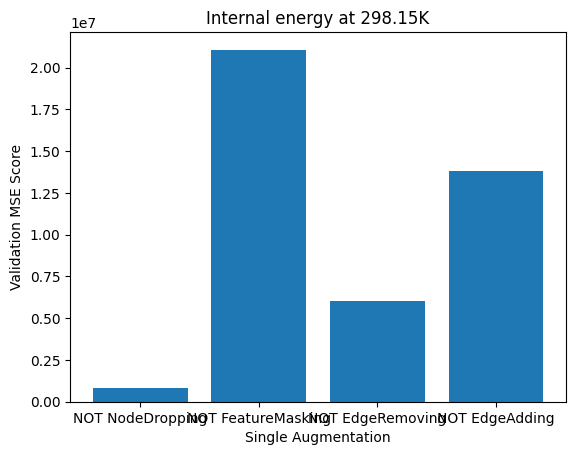

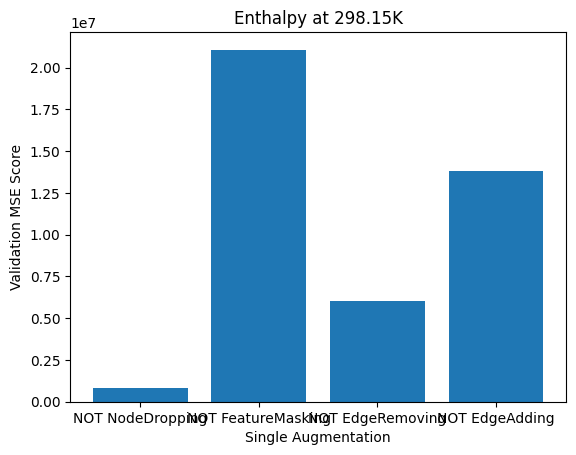

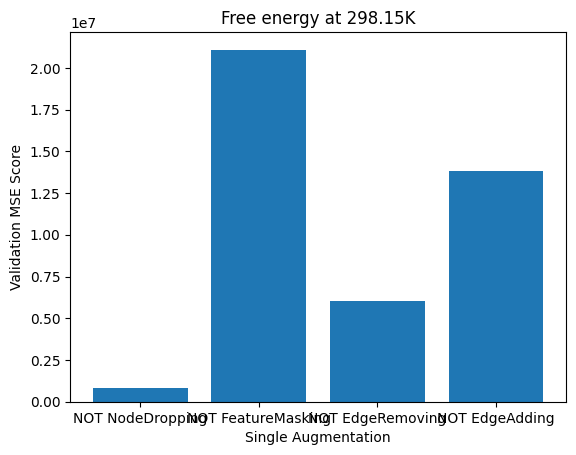

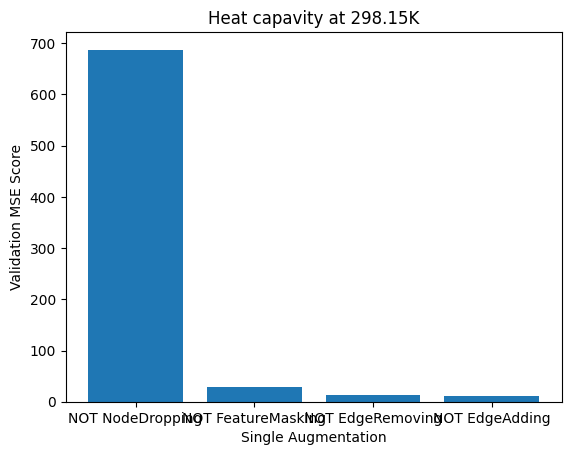

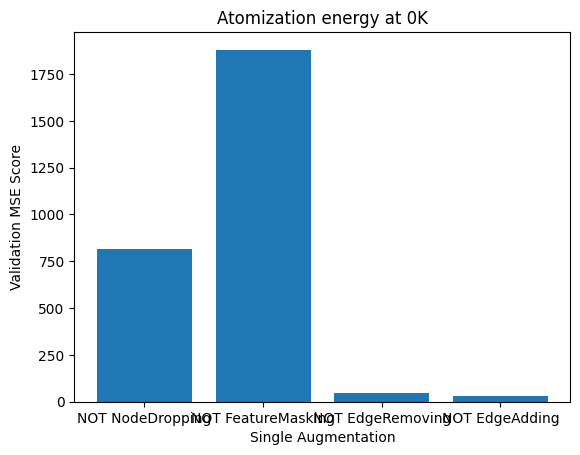

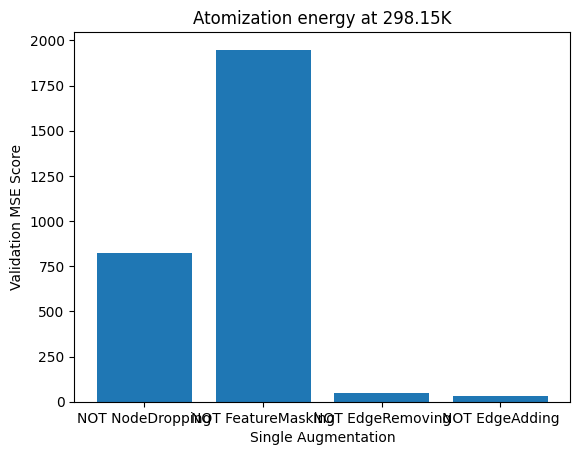

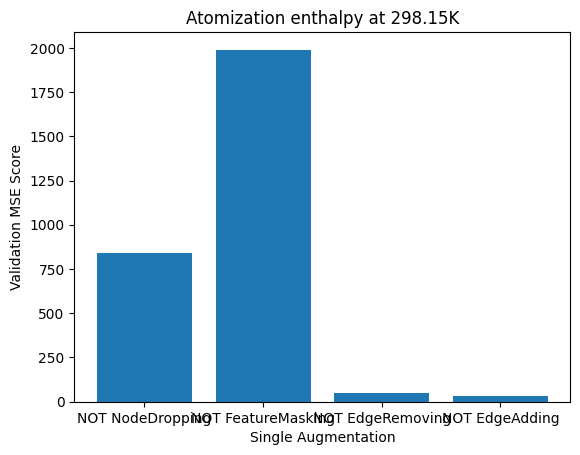

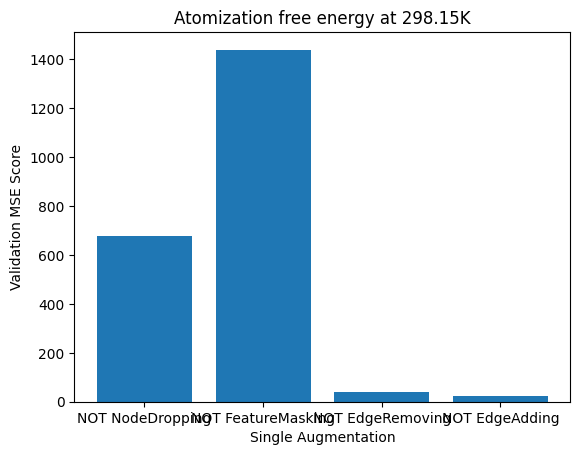

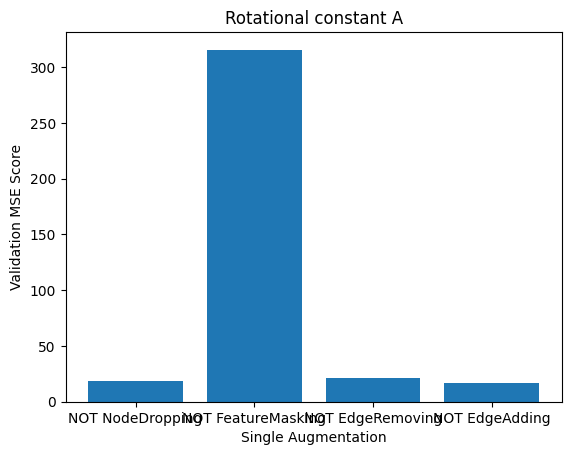

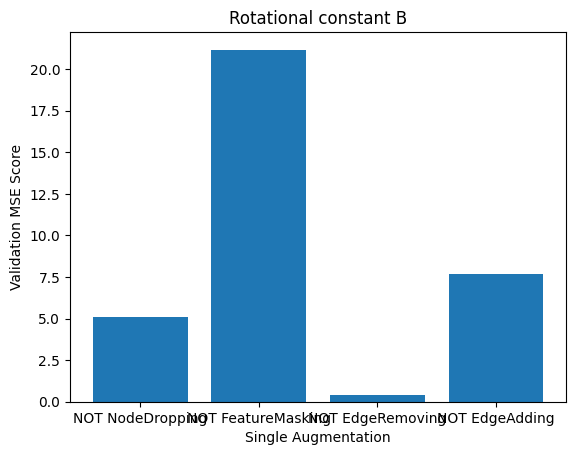

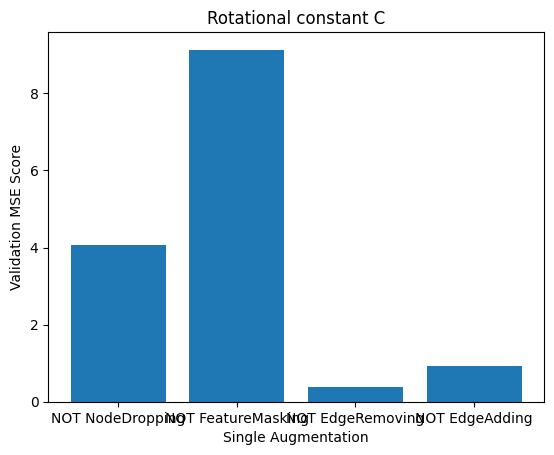

In [43]:
# For all-but-one-augmentation
mse_scores = torch.zeros((19, len(aug_strs)))

#augs = os.walk('aug_sweep3-4')
print(next(os.walk('aug_sweep3-4'))[1])

for i_str, stri in enumerate(next(os.walk('aug_sweep3-4'))[1]):
    vec = torch.load(f'aug_sweep3-4/{stri}/val_loss.pt')
    
    model = GCN().to(device)
    model.load_state_dict(torch.load(f'aug_sweep3-4/{stri}/model.pt'))
    
    plt.plot(vec, label = stri)
    print(vec)
    
    for batch in big_train_loader: # take entire train set
        with torch.no_grad():
            # Embed training set under model
            rep_tr, _ = model(val_aug(batch.x, batch.edge_index, batch.edge_attr), batch.batch.to(device))


            for val_batch in val_loader:
                # Embed validation set under model
                rep_val, _ = model(val_aug(val_batch.x, val_batch.edge_index, val_batch.edge_attr), val_batch.batch.to(device))

                # For each task in QM9
                for tar_ind in range(batch.y.shape[1]):
                    # Fit a model on model representation of train set

                    #print(rep_tr.shape, batch.y[tar_ind].shap)
                    lm = LinearRegression().fit(rep_tr.cpu(), batch.y[:,tar_ind])
                    # Test the model on model repersentation of val set
                    tar_yhat = lm.predict(rep_val.cpu())
                    mse_met = mean_squared_error(val_batch.y[:,tar_ind], tar_yhat).item()
                    r2_met = r2_score(val_batch.y[:,tar_ind], tar_yhat)
                    #print(qm9_index[tar_ind], mse_met, r2_met)
                    mse_scores[tar_ind, i_str] = mse_met
    
plt.legend()
plt.show()

#print(mse_scores, mse_scores.shape)

# For one score, 



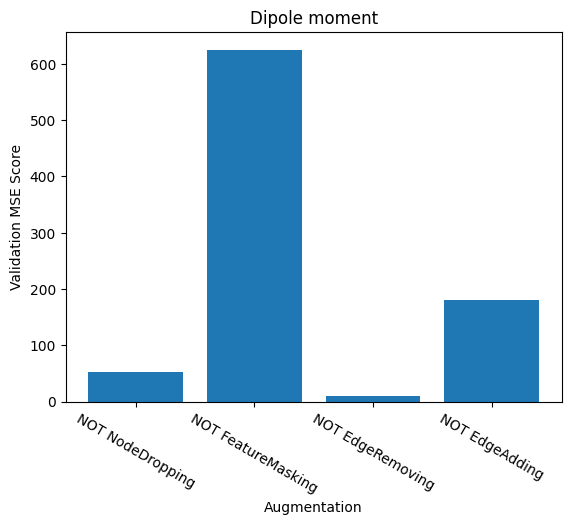

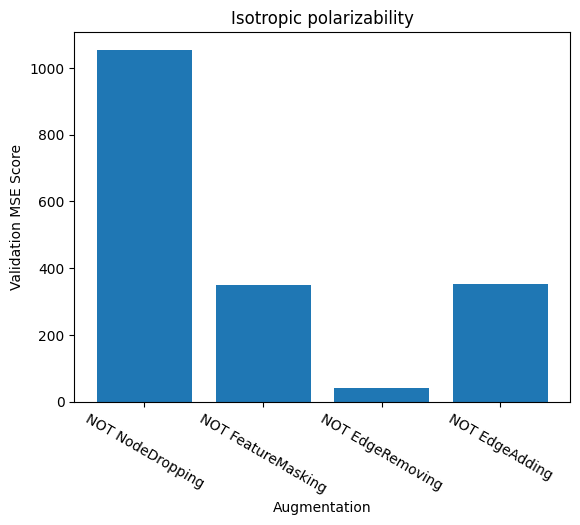

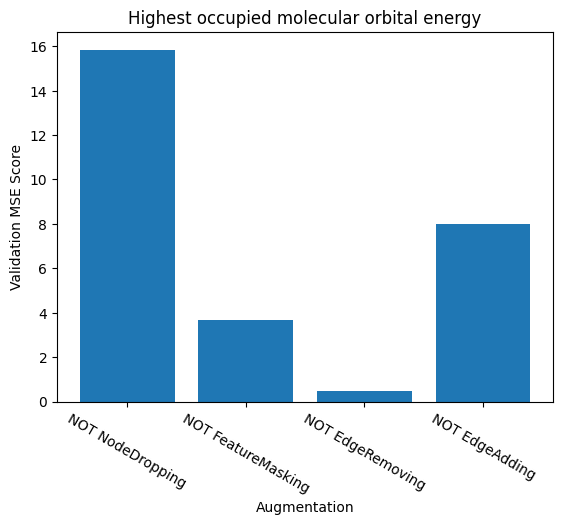

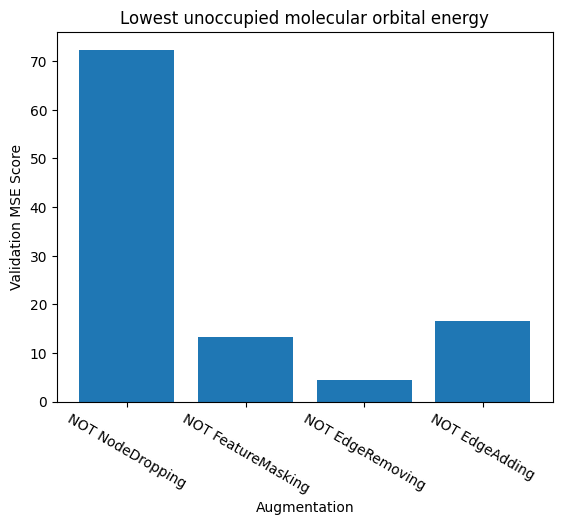

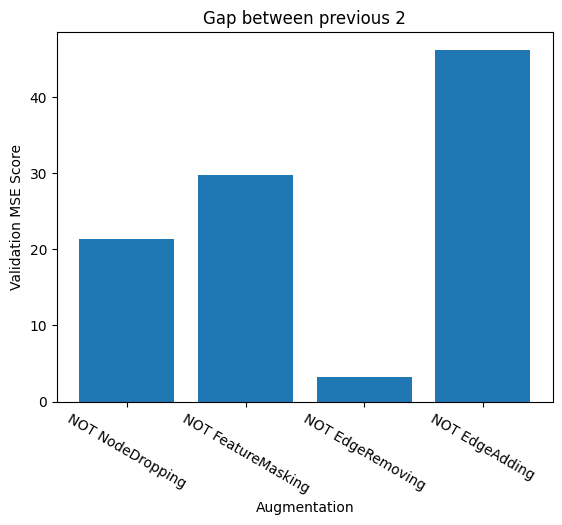

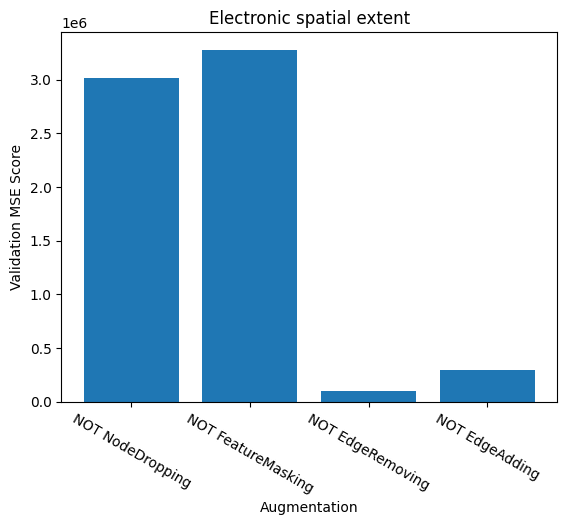

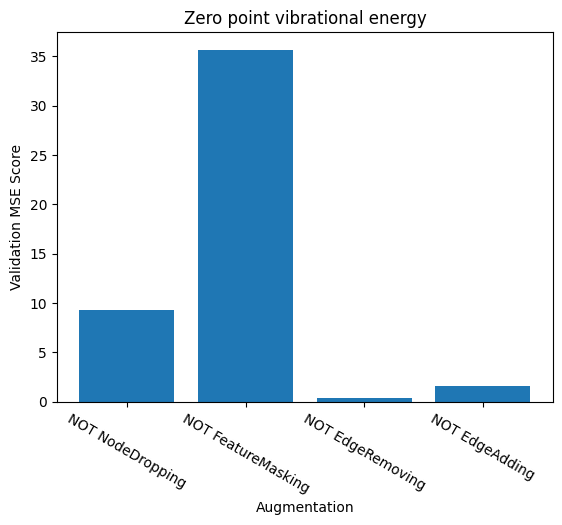

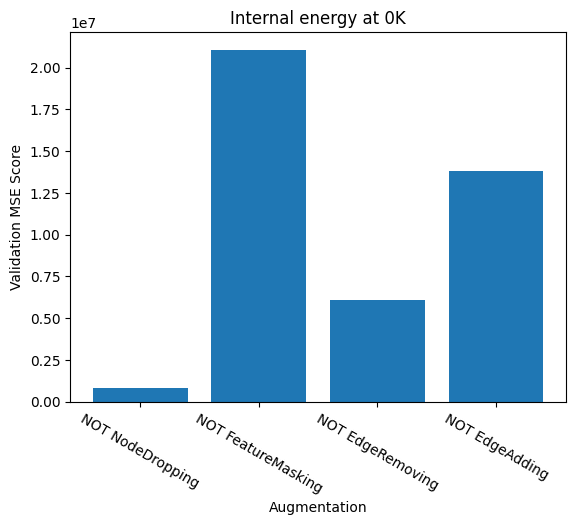

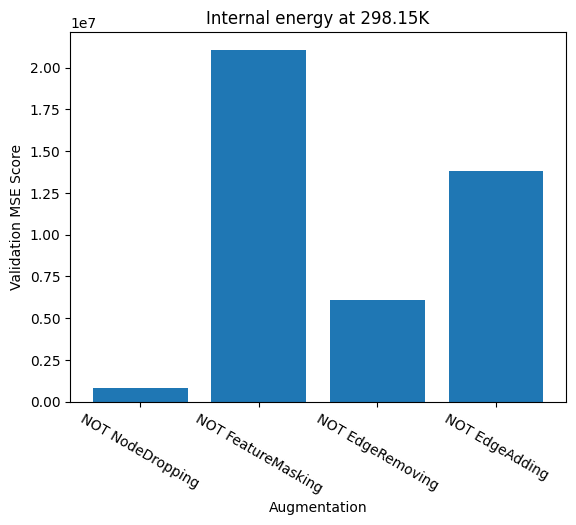

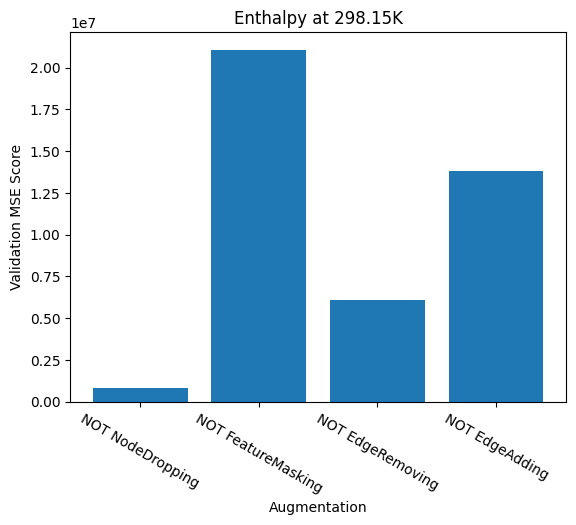

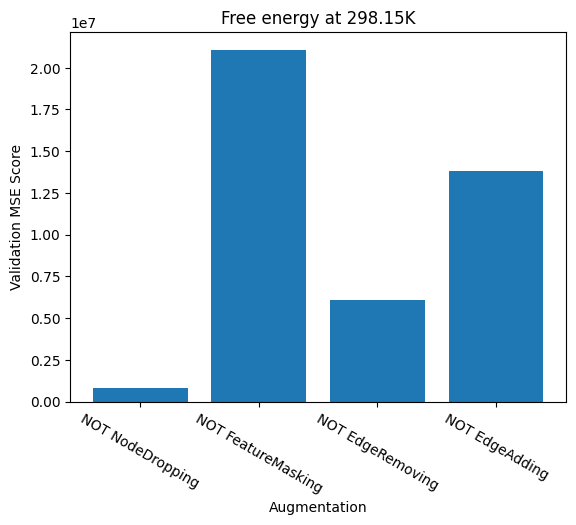

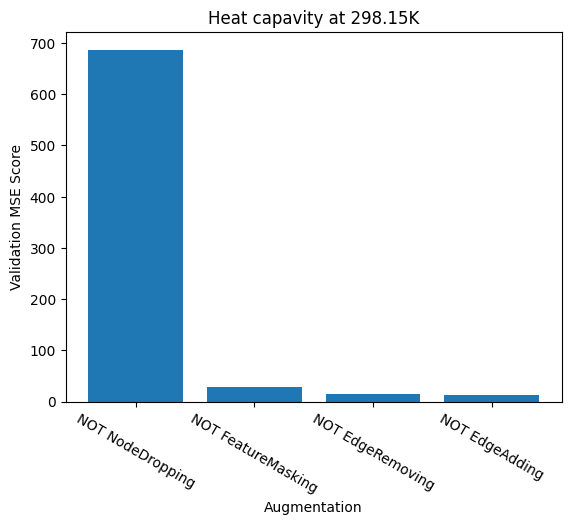

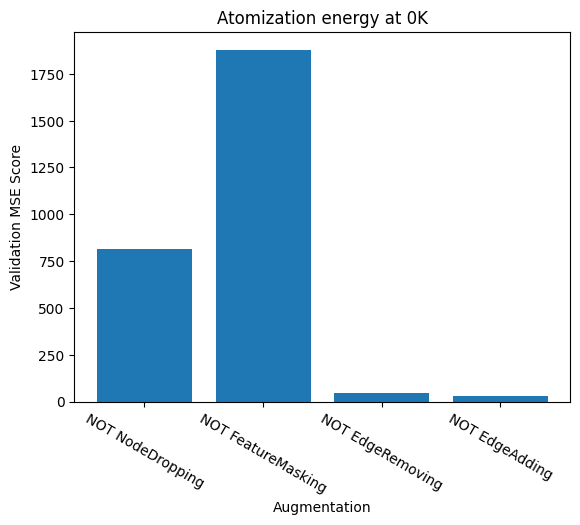

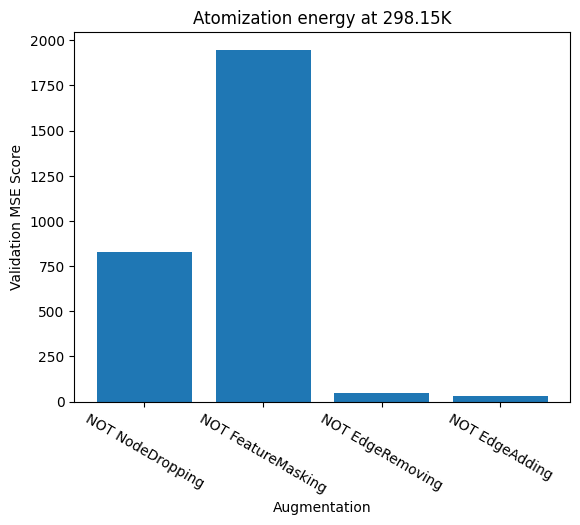

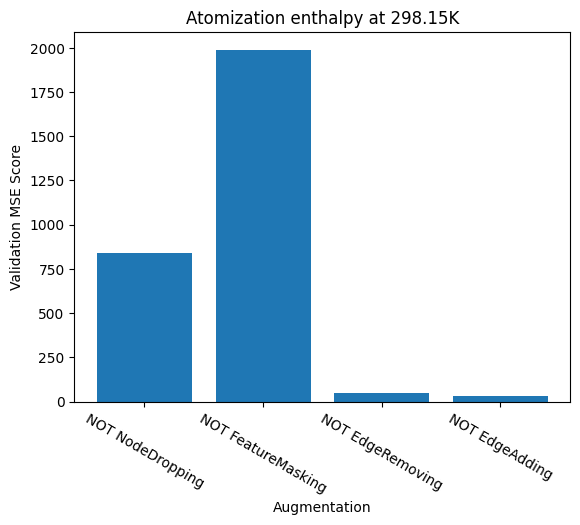

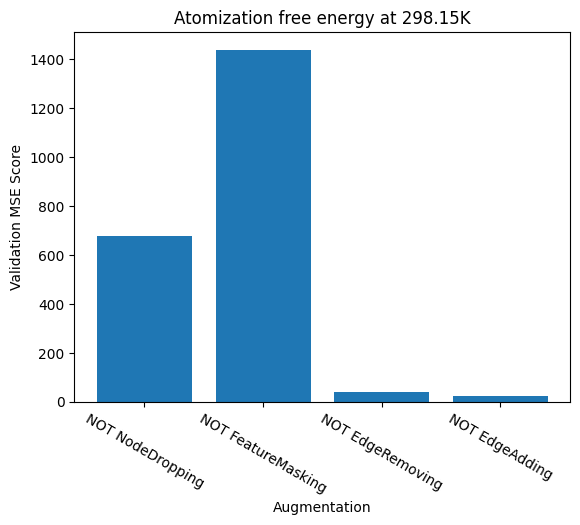

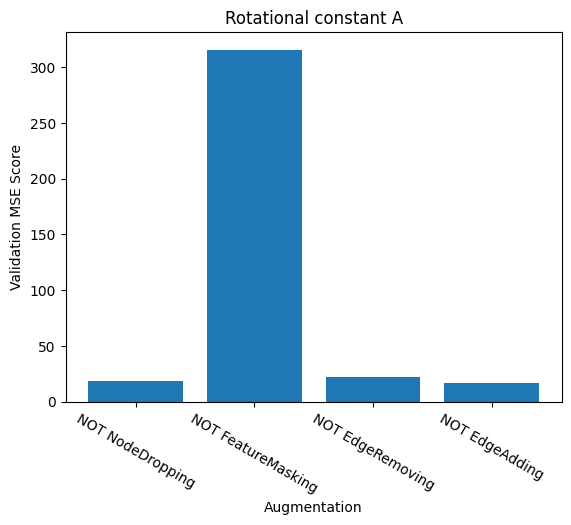

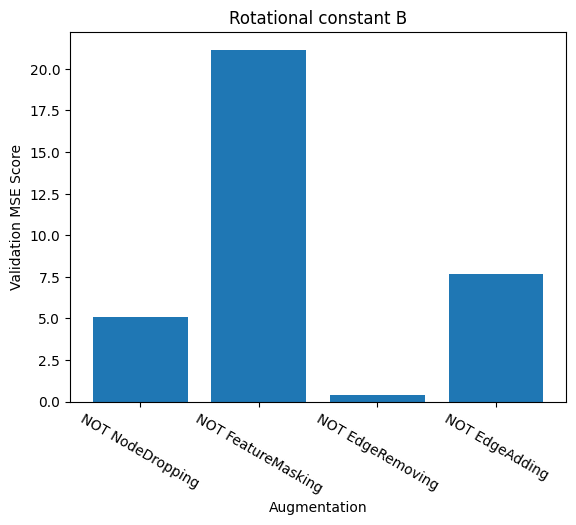

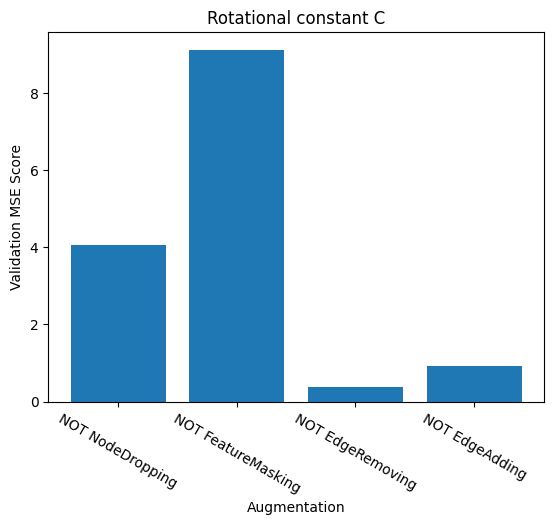

In [61]:
# I would also add a column for "naive estimator"
# This could be a simple regressor, or a mean estimator (like Eric)

for i, row in enumerate(mse_scores):
    name = qm9_index[i]
    
    plt.bar(x = range(len(row)), height = row)
    plt.xticks(range(len(row)), ['NOT '+x for x in aug_strs], rotation = -30)
    plt.xlabel('Augmentation')
    plt.ylabel('Validation MSE Score')
    plt.title(name)
    
    plt.savefig(f'imgs/3-4_{qm9_index[i]}.png', bbox_inches = 'tight')
    plt.savefig(f'imgs/3-4_{qm9_index[i]}.pdf', bbox_inches = 'tight')
    plt.show()
    

PLEASE NOTE THESE ARE RANKS INTEGERS NOT INDEXES:
torch.Size([19, 4])
tensor([2.5789, 3.5789, 1.5789, 2.2632])


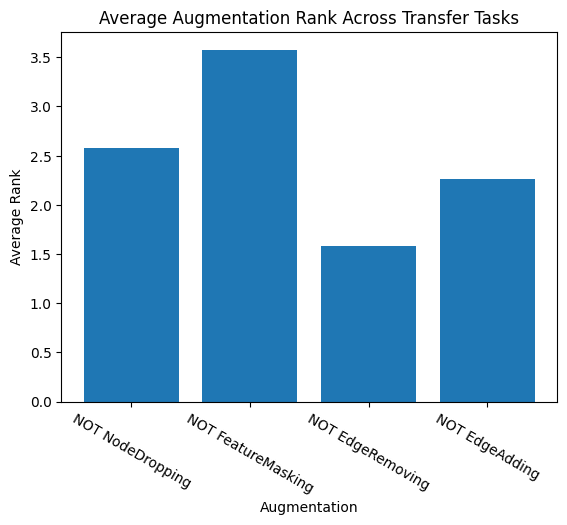

In [62]:
# Further step would be summarizing the average ranks of the models to summarize 19 QM's into 1 rank
import scipy.stats as ss
# For each QM9_index, find the min of the row -> this index is the best augmentation
print('PLEASE NOTE THESE ARE RANKS INTEGERS NOT INDEXES:')

ranks = []
for i, row in enumerate(mse_scores):
    elem = torch.argmin(row).item()
    #print(qm9_index[i], elem)
    
    # For each element of the qm9 row, 
    rank = ss.rankdata(row)
    #print(row, ranks)
    
    ranks.append(torch.FloatTensor(rank))
    
ranks = torch.stack(ranks)
print(ranks.shape)
meanranks= torch.mean(ranks, dim = 0)
print(meanranks)

plt.bar(range(4), meanranks)
plt.xticks(range(4), ['NOT '+x for x in aug_strs], rotation = -30)
plt.ylabel('Average Rank')
plt.xlabel('Augmentation')
plt.title('Average Augmentation Rank Across Transfer Tasks')
plt.savefig(f'imgs/3-4_{qm9_index[i]}.png', bbox_inches = 'tight')
plt.savefig(f'imgs/3-4_{qm9_index[i]}.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
# ALso making the above plots for one-at-a-time